# **Paper Information**

**Paper Title:** STGAN: A Unified Selective Transfer Network
for Arbitrary Image Attribute Editing [https://arxiv.org/pdf/1904.09709.pdf](https://arxiv.org/pdf/1904.09709.pdf)

**Paper Authors:** Ming Liu, Yukang Ding, Min Xia, Xiao Liu, Errui Ding, Wangmeng Zuo, Shilei Wen

**Project Group Members:** Ali İlker Sığırcı, İlyas Eren Yılmaz

**Contact Information:** e217194@metu.edu.tr, e217220@metu.edu.tr


## **Paper Summary**

### **Introduction**

![1](./notebook_images/1.png)

In image attribute editing, the goal is to manipulate an image
with desired attributes but this is a hard problem. Since there isn't enough paired images with/without these attributes, we can only use models such as encoder-decoder and GANs. 

Unfortunately, using encoder-decoder architecture for multi-domain image-to-image translation tasks has limited success. The problem here is that the latent layer becomes a restriction and this results in low quality, blurry images. Researches introduces skip connection to get high quality images but this reduces the freedom of attribute manipulation. 

Moreover, some existings methods like STARGAN takes image and its corresponding full attribute vector as a input. Later, we will discuss that this is actually not a good approach.  

To address the above issues, the authors introduce STGAN model.
The model has two important features that are different from different from the rest:
* Taking attribute difference vector as input
* Transfer encoder output to decoder with Selective Transfer Unit(STU)

![2](./notebook_images/2.png)

Thanks to these important features, they able to fully reconstruct the original image. Morever as you see from the above figure, STGAN model can better edit the attributes than the state-of-the-art models.

In the paper, CelebA dataset is used which contains 40 different attributes. Among them, the authors choose 13 attributes. The reason is that this attributes result in better distintive view.
The attributes are:
* Bald, Black Hair, Blond Hair, Brown Hair
* Bangs, Eyebrows, Eyeglasses, Gender, Mouth Open, Mustache, No Beard,Pale Skin, Age

## Architecture

### General Structure

![3](./notebook_images/3.png)

The model is consist of two components,a generator G and a discriminator D.
The generator G has an encoder G_enc for abstract latent representation, a decoder G_dec for target image generation, and G_st consists of a series of selective transfer units
(STUs) for selective feature transfer.

The discriminator D has two branches D_adv and D_att.
D_adv decides whether an image is fake or not and D_att predicts an attribute vector.

Moreover, as can be seen in the figure, generator has:
* 5 encoder layers with kernel size as 4 and stride as 1.
* 4 STU shortcut layers for transfering encoder features.
* 5 decoder layers with kernel size as 4 and stride as 2.

#### Introducing Attribute Difference

Existing methods such as StarGAN or AttGAN take whole attribute vector as a input to the model.

The authors discuss that taking attribute difference as input gives better result.
For example, if we want to remove smile effect from the picture, we just change its correspending attribute and feed only this vector to the model rather than the whole attribute vector.

With this way, the authors show that, they get near perfect reconstruction since there is no attribute difference between source and target image attributes. Moreover, this method makes the attribute editing more intuitive since the user of the model doesn't need to know about the whole attribute vector. Instead s/he just need to know what attribute s/he would like to change. This approach makes the interactive editing more robust and easy to use. 

#### STU Structure

![4](./notebook_images/4.png)

The authors introduce Selective Transfer Units to transder encoder features to the decoder.
Existing methods only concatanes encoder output to decoder and it is called the skip connection.
But in here, it is more like a calculated shortcut layer.

The authors took the structure of GRU as a base and modify it. The structure and its corresponding formulation can be seen in the figure.

## LOSS
The input of the generator and output of the generator is generalized as following in order to simplify the formulas

![5](./notebook_images/5.png)

### Reconstruction Loss

Reconstruction loss calculated for generator by giving input images and attribute difference vector as zero. Since the difference is zero generator must generate the same image as output. The L1 norm between input and output is the resulting reconstruction loss.

![6](./notebook_images/6.png)

### Adverserial Losses

Adverserial losses of discriminator consists of two main parts. The first part of the equation is the general GAN loss for discriminator. The second part is the gradient penalty. Gradient penalty is calculated by taking a sample along lines between pairs of real and generated images which is called x hat and calculating the gradient of output of discriminator given x hat as input. The output gradients are then put into l2 norm. Final product is generally multiplied with gradient penalty constant lambda.

Adverserial loss of generator is the same as GAN adverserial losses for generators. The generated fake images are passed to discriminator and then resulting values are optimized.

![7](./notebook_images/7.png)


### Attribute Manipulation Losses

These losses are used to check whether the target attribute requirements are met for generator and whether dicriminator can detect attributes correctly.

![8](./notebook_images/8.png)

### Model Objective

Following structures are the total loss functions for generator and discriminator. In the paper and our implementations model tradeoff parameters lambda values are taken as 1,10 and 100 respectively.

![9](./notebook_images/9.png)
![10](./notebook_images/10.png)

# Global Imports

In [2]:
import os
import torch
import matplotlib.pyplot as plt
%matplotlib inline 

from resources import *

%load_ext autoreload
%autoreload 2

In [3]:
from platform import python_version

print(python_version())
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)

3.8.8
1.8.1
cpu


In [4]:
#Global parameters of the STGAN
learning_rate = 2 * 10E-4 # Learning Rate of Discriminator and Generator given to optimizer Adam
encoding_dim = 64 # Encoding dimension of Discriminator and Generator
image_size = 64 # Size of images expected by models
attribute_dim = 13 # Number of attributes
fc_dim = 1024
batch_size = 32
num_epochs = 3
beta1 = 0.5
beta2 = 0.999
lamb = 10
lamb1 = 1
lamb2 = 10
lamb3 = 100
# epsilon = 1e-9 #used to avoid getting Nan in result of torch.log in attribute manip losses

set_seeds(796)

# For training intermediate outputs
if not os.path.exists("images"):
  !mkdir "images"

# DATASET

## Download Dataset (CELEBA)

Instead of download_data.sh script, use this cell instead (optional)

Downloading a large file from google drive is a bit tricky. So we provide 
this cell to make it more intuitive.

NOTE: Data size is about 1.5G


In [4]:
# Download And Extract Data

import gdown
import os

data_root = 'data'
data_file_name = "ceng796_project_data.tar.xz"
data_url = "https://drive.google.com/uc?id=1-QLU_-u5RErsMppPq6d74waBLnreehAM"

if not os.path.exists(data_root):
    gdown.download(data_url, data_file_name, quiet=True)
    !tar -xzf ceng796_project_data.tar.xz
    !rm -rf ceng796_project_data.tar.xz

## Load Dataset

In [5]:
## Import CelebA Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
data_root = 'data'
celeba_train_data = datasets.CelebA(data_root,
                              download=False,
                              split='train',
                              transform=transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                        std=[0.5, 0.5, 0.5])
                              ]))

celeba_test_data = datasets.CelebA(data_root,
                              download=False,
                              split='test',
                              transform=transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                        std=[0.5, 0.5, 0.5])
                              ]))

# Dataloader is used to shuffle the corresponding sets and create separate batches of data
# Every batch consists of two tensors. First tensor holds the input images and second tensor holds the attributes of the images respectively
train_loader = DataLoader(celeba_train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(celeba_test_data,  batch_size=batch_size, shuffle=False)

print(celeba_train_data)
print(celeba_test_data)

Dataset CelebA
    Number of datapoints: 162770
    Root location: data
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset CelebA
    Number of datapoints: 19962
    Root location: data
    Target type: ['attr']
    Split: test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


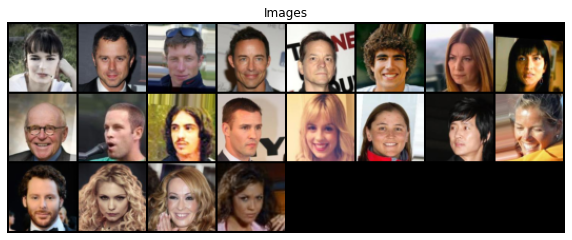

In [6]:
# Showing images of real examples from CelebA

images = next(iter(train_loader))[0]

show_images_new(images)

# TRAINING

IMPORTANT NOTE:

We have used colab notebook for training. It took approximately 5 hours for 1200 iterations, which can be seen in the tqdm output of the below cell. In case the training output doesn't show on your local computer, please upload the notebook to colab.

We think there is a rendering problem in local jupyter notebook. But in colab, everything should be displayed as expected.

In [10]:
#Training section 
from tqdm.notebook import tqdm
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# Generator Model is instantiated
gen = Generator(encoding_dim, attribute_dim) 
gen = gen.to(device)  

# Discriminator Model is instantiated
disc = Discriminator(image_size, encoding_dim, fc_dim, attribute_dim) 
disc = disc.to(device)  

# Adam is used as the optimizer with the parameters and betas given by the STGAN paper
optim_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(beta1, beta2))
optim_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta1, beta2))

model_progress = []
disc_training_loss = []
gen_training_loss = []
disc_loss_per_batch = []
gen_loss_per_batch = []

attr_class = Attribute()

for epoch in range(1, num_epochs+1):

    gen.train()
    disc.train()
    disc_running_loss = 0.0
    gen_running_loss  = 0.0

    for index, (org_images, org_attrs) in tqdm(enumerate(train_loader)):

        """
        target_attrs = torch.zeros([batch_size, attribute_dim])

        for i in range(batch_size):
            target_attrs[i] = attr_class.generate()
        
        target_attrs = target_attrs.to(device)
        """
        org_images = org_images.to(device)

        # selected_attr_indices = [4, 5, 8, 9, 11, 12, 15, 20, 21, 22, 24, 26, 39]
        # org_attrs = org_attrs[:, selected_attr_indices]
        #org_attrs_class = org_attrs.clone()

        org_attrs = attr_class.transform_original_attributes(org_attrs)

        # randomly shuffle original attributes to generate target attributes
        random_indices = torch.randperm(org_attrs.shape[0])
        target_attrs = org_attrs[random_indices]
        #target_attrs_manipulation = target_attrs.clone()
        
        org_attrs = org_attrs.to(device)
        #org_attrs_manipulation = org_attrs_manipulation.to(device)

        target_attrs = target_attrs.to(device)
        #target_attrs_manipulation = target_attrs_manipulation.to(device)

        # print("Original Attributes shape ", org_attrs.shape)
        # print("Target Attributes shape ", target_attrs.shape)

        # Discriminator Training and Loss
        discr_loss = discr_model_obj(disc, gen, org_images, org_attrs, target_attrs, lamb, lamb1, device)
        disc_loss_per_batch.append(discr_loss)
        disc_running_loss += discr_loss.item()

        optim_disc.zero_grad()
        discr_loss.backward()
        optim_disc.step()

        # Generator Training and Loss
        gen_loss = gen_model_obj(disc, gen, org_images, org_attrs, target_attrs, lamb2, lamb3, device)
        gen_loss_per_batch.append(gen_loss)
        gen_running_loss += gen_loss.item()

        optim_gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()

        if index % 30 == 0:
            save_state(gen, optim_gen, index, "gen_test", path="./")
            save_state(disc, optim_disc, index, "discr_test", path="./")

            org_image_path =  f'images/img_org_{index}.jpg'
            gen_image_path =  f'images/img_gen_{index}.jpg'

            # print("index", index)
            # print("target_attributes", attr_class.get_attr_names(target_attrs))
            # print("original_attributes", attr_class.get_attr_names(org_attrs))
            # print("attribute_difference", attr_class.get_attr_difference_names(org_attrs, target_attrs))

            print("discr_loss", discr_loss.item())
            print("gen_loss", gen_loss.item())

            save_images_new(org_images, org_image_path )
            gen_images = gen(org_images, target_attrs-org_attrs)
            save_images_new(gen_images, gen_image_path)
          
    disc_running_loss /= len(train_loader.dataset)
    gen_running_loss /= len(train_loader.dataset)
    disc_training_loss.append(disc_running_loss)
    gen_training_loss.append(gen_running_loss)


0it [00:00, ?it/s]

RuntimeError: [enforce fail at inline_container.cc:274] . unexpected pos 13147584 vs 13147472

## Intermediate Training Results

<!---
### Iteration 0 - Original vs Generated

<p float="left">
  <img src="notebook_images/img_org_0.jpg" >
  <img src="notebook_images/img_gen_0.jpg">
</p>

### Iteration 400 - Original vs Generated

<p float="left">
  <img src="notebook_images/img_org_400.jpg" >
  <img src="notebook_images/img_gen_400.jpg">
</p>

### Iteration 800 - Original vs Generated

<p float="left">
  <img src="notebook_images/img_org_800.jpg" >
  <img src="notebook_images/img_gen_800.jpg">
</p> --->

# Pretrained Models

## Download Pretrained Generator/Discriminator

In [10]:
model_root = 'models'
model_file_name = "ceng796_project_models.tar.xz"
model_url = "https://drive.google.com/uc?id=1FCmLtTJrtfmzau6jtdiD22rAnyayuoKt"

if not os.path.exists(model_root):
    gdown.download(model_url, model_file_name, quiet=True)
    !tar -xzf ceng796_project_models.tar.xz
    !rm -rf ceng796_project_models.tar.xz

## Load Pretrained Generator/Discriminator

In [12]:
disc = Discriminator(image_size, encoding_dim, fc_dim, attribute_dim) 
optim_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(beta1, beta2))
load_state(disc, optim_disc, "models/discr_test.pth", mode="test", device = device)

gen = Generator(encoding_dim, attribute_dim)
optim_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta1, beta2))
load_state(gen, optim_gen, "models/gen_test.pth", mode="test", device = device)

# TESTING

### One Time

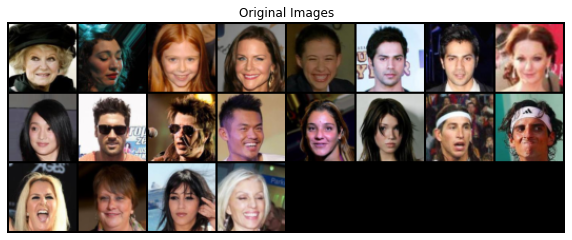

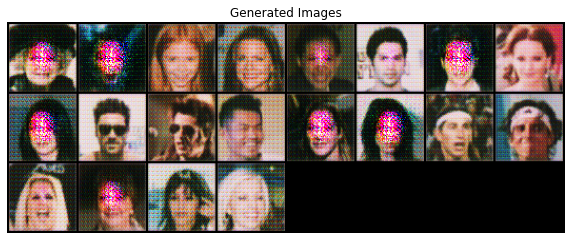

In [15]:
test_images, test_attrs = next(iter(test_loader))

target_attrs  = generate_target_attr()
attr_diff = test_attrs - target_attrs
attr_diff = attr_diff.to(device)

test_images = test_images.to(device)
test_attrs = test_attrs.to(device)
gen = gen.to(device)

show_images_new(test_images, device, title="Original Images")
gen_images = gen(test_images, attr_diff)
show_images_new(gen_images, device, title="Generated Images")

### Whole Dataset

In [ ]:
#Testing Section

model_test_results = []

with torch.no_grad():
    
    gen.eval()
    disc.eval()

    for (org_images, org_attrs) in test_loader:
        
        target_attrs  = generate_target_attr()
        attr_diff = org_attrs - target_attrs
        attr_diff = attr_diff.to(device)

        org_images = org_images.to(device)
        org_attrs = org_attrs.to(device)

        gen_images = gen(org_images, attr_diff)
        fake_classes, fake_attrs = disc(gen_images)
        model_test_results.append((org_images, target_attrs, gen_images, fake_classes))    

# IMPLEMENTATION CHALLENGES

There were several problems occured while implementing the STGAN paper. The explanation of these problems are listed one by one down below.
- The paper explains the main structure and provide an extra supplementary for the model structure itself and many more qualitative results. However, there are many implementations tricks that needed to be done in order to be able to implement the model correctly. In the supplementary section, the encoder and decoder parts of the generator was listed. The listing contains the sequence of layers both  encoder and decoder contain. But the main structure of the decoder must be inversed in order to get correct results and match STGAN. The picture of the model structure in the supplementary section only provides this information by numbering the layers of both parts and these numbers are very small to understand at first. Thus the paper is not pointing the critical details of implementations.
- The losses in the paper are explained fairly great. Steps of calculations are clear and general loss functions are understandable as formulas. However the implementation details are never explained and the problems that occur due to the difference between real world and mathematical world appears while trying to implement the loss functions. There are unlisted improvements that needed to be done in order to get correct reconstruction results and generations with target attributes.
- The output of the generator might result in zero values or one values which might produce NaN as a result of taking logs in attribute manipulation losses. To overcome this issue, the attributes and classes produced by the discriminator is assumed to be taking logs. Thus to use this variables, exponentials of them needed to be taken. Also to resolve the taking log of zero problem logsigmoig function is used on the attributes produced by discriminator to ensure that inner of log is never equal to zero.
- The training times of the network is fairly long. Local devices that we used resulted in weeks to complete the training. Hence we decided to put our code into the Google Colab. We transferred all of our codebase and trained the remaining time training in Colab. However one epoch approximately takes 2 hours to complete with CelebA. Moreover Colab limits the usage of GPUs by 12 hour per user and checks frequently whether the user left Colab alone or not. In order to overcome this, we tried to save and load model on different epoch intervals and changed the number of epoch accordingly in order to complete training.
- CelebA is a very big dataset that needed to be preprocessed before being used. Attribute vectors and their corresponding images are given in dataset itself. Also CelebA implementation of the PyTorch is connecting to Google Drive url of the CelebA dataset but the url download from teh Google drive is limited and trying to download the dataset by using PyTorch implementation results in error. To overcome this problem, we copied the CelebA dataset into our Google Drive from the Google Drive page of CelebA directly and created a copy cell that puts files to the destination that PyTorch implementation of CelebA wants. Then the CelebA implementation of the PyTorch is used to parse data and pass to DataLoader.

Due to the large amount of training time and obstacles occured on the way of implementating the paper, 
we could not met our goals. To decrease the training time we tested with different hyperparameters such as different
combinations of batch_size, learning rate and epochs. However nearly every training were too long to be completed by Google Colab 
or our GPUs. 

For the next review we will try to get a more powerful GPU and try to create a mechanism to continue training 
our pretrained model. 

As a final word, paper includes the main explanation of the system however the implementation details and challenges are not provided in the paper. Many details are left to the understanding of the reader and are not explained in detail.